<a href="https://colab.research.google.com/github/abinabrahamjohn/NLP_Mini_Projects/blob/master/Knowledge_Graph_using_Spacy_and_Networkx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
dir_path = "/content/drive/My Drive/NLP Colab Notebooks/"
candidate_sentences = pd.read_csv(dir_path+"Data/wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [ ]:
candidate_sentences['sentence'].sample(5)


3184                      highlander, a film about immortal scottish swordsmen, was released the same year.
4256                                                           i am signing on not to 'take over' from sam.
1135    skbh productions next film will be shikshanachya aaicha gho, a remake directed by mahesh manjrekar.
2565                                                   cfcc has its precise roles and functions as follows:
2349                                                        cooper and tars are ejected from the tesseract.
Name: sentence, dtype: object

In [ ]:
doc = nlp("highlander, a film about immortal scottish swordsmen, was released the same year")

for tok in doc:
  print(tok.text, "...", tok.dep_)

highlander ... nsubjpass
, ... punct
a ... det
film ... appos
about ... prep
immortal ... amod
scottish ... amod
swordsmen ... pobj
, ... punct
was ... auxpass
released ... ROOT
the ... det
same ... amod
year ... npadvmod


In [ ]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [ ]:
get_entities("dada has one son")

['dada', 'one  son']

In [ ]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:38<00:00, 111.33it/s]


In [ ]:
entity_pairs[10:20]


[['we', 'tests'],
 ['m global', 'international sales rights'],
 ['robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['', 'military  arrest'],
 ['train', 'vuk'],
 ['telepath', 'gallio'],
 ['singer', 'men']]

In [ ]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [ ]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]


100%|██████████| 4318/4318 [00:37<00:00, 114.65it/s]


In [ ]:
pd.Series(relations).value_counts()[:50]

is               370
was              297
released on       87
include           73
were              71
are               71
released          40
's                38
composed by       35
has               31
have              31
became            31
become            29
released in       27
included          26
called            22
produced          22
had               20
made              20
considered        20
be                18
been              18
used              17
scheduled         17
directed by       16
stars             16
written by        15
set               14
hired             14
produced by       14
wrote             14
received          13
went              13
introduced in     13
wanted            12
began in          11
began             11
won               11
gave              10
sold              10
features          10
shot in            9
produced in        9
opened             9
reported           9
directed           9
gives              9
includes     

In [ ]:

# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [ ]:

# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

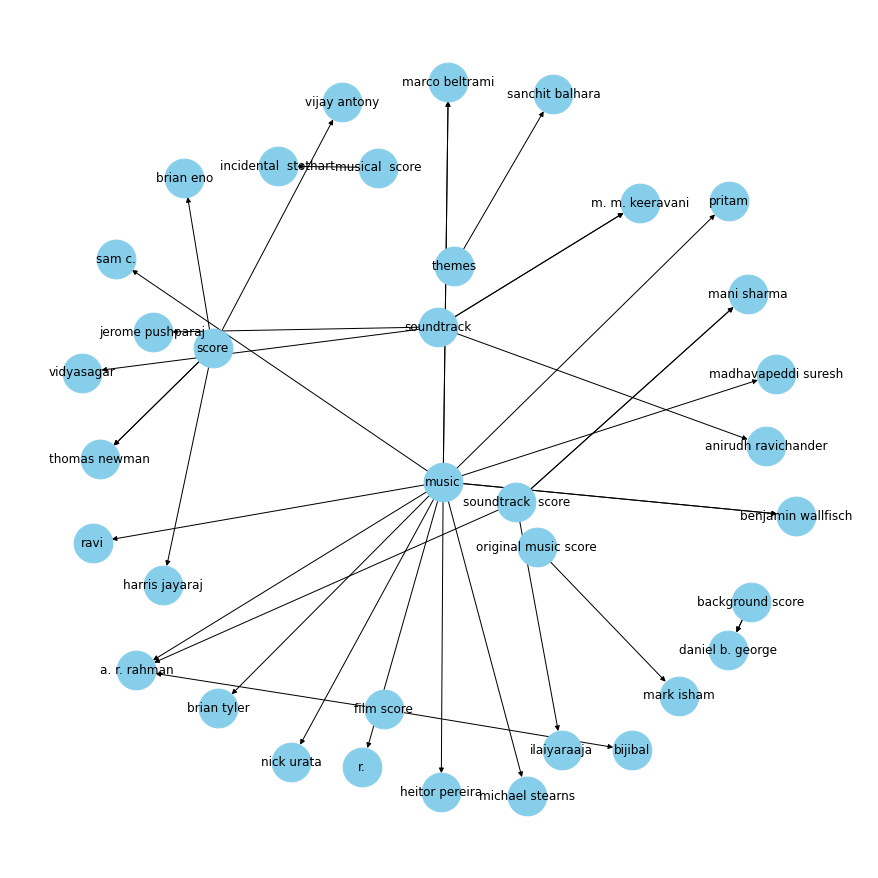

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

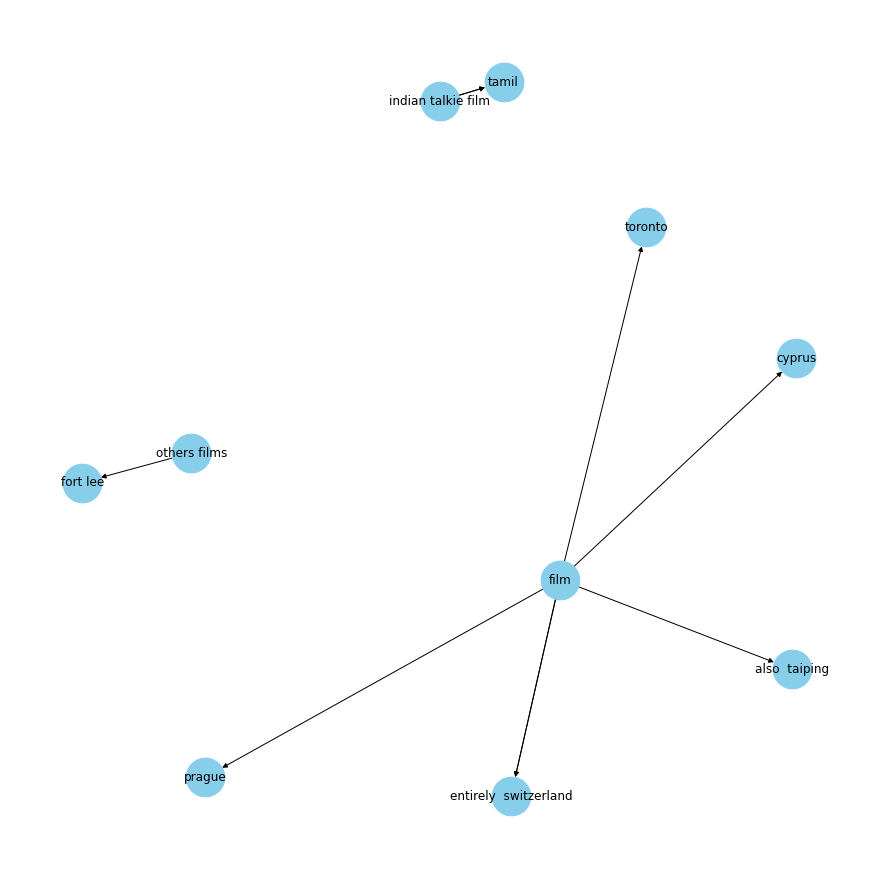

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="shot in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()